In [2]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import os
import numpy as np
import scipy.stats as st

In [9]:
filename = "./2025-05-18-RandomForest-2.csv"
df = pd.read_csv(filename)
df["n_samples"] = df["n_samples"].astype(str)
df.to_csv(filename)

In [4]:
df = pd.read_csv("./2025-05-20-HuggingFaceClassification.csv")
df["n_samples"] = ["Entraînement Hugging Face"] * len(df)
df.to_csv("./2025-05-20-HuggingFaceClassification.csv", index = False)

In [17]:
method_filename = {
    "RandomForest" : "2025-05-18-RandomForest-2.csv",
    "KNN" : "2025-05-18-KNN-2.csv",
    "OneLayer" : "2025-05-18-MLPOneLayer-2.csv"
}
named_dataset = {}
for method in method_filename : 
    named_dataset[method] = pd.read_csv(method_filename[method])
    named_dataset[method]["method"] = [method] * len(named_dataset[method])

# Concatenate the dataframes : 
df = None
for method in named_dataset:
    if df is None: df = named_dataset[method]
    else: df = pd.concat((df, named_dataset[method]))

# df = df.drop(["Unnamed: 0"], axis = 1)
df["model"] = df["filename"].apply(lambda x : '-'.join(x.split("-")[3:-3]))
df["lr"] = df["filename"].apply(lambda x : '-'.join(x.split("-")[-3:-1]))
df["lr"] = df["lr"].astype(float)

In [18]:
print((
    f"Le df contient {len(df)} lignes.\n"
    f"Par modèle de plongement on compte {df.groupby('model').size().iloc[0]} lignes\n"
    f"Par modèle de classification on compte {df.groupby('model').size().iloc[0]} lignes"
))

Le df contient 1944 lignes.
Par modèle de plongement on compte 648 lignes
Par modèle de classification on compte 648 lignes


(np.float64(0.5102778807472418), np.float64(0.5190102308298493))


<Axes: >

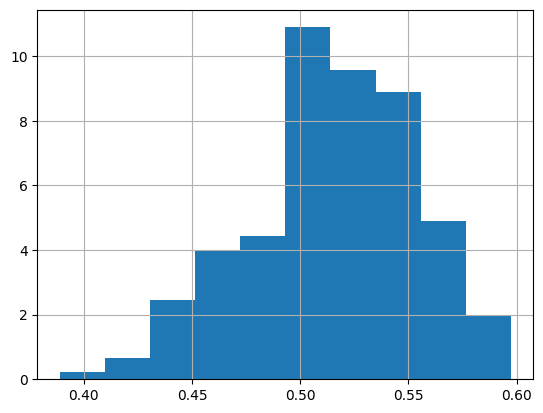

In [31]:
from scipy.stats import sem
serie = df.loc[
    (df["model"] == "answerdotai/ModernBERT-base")&(df["method"] =="RandomForest"),
    "f1_macro"
]
print(
    t.interval(0.9, len(serie), loc= serie.mean() , scale = sem(serie))
)
serie.hist(density=True)

### Meilleur score par modèle

In [38]:
df_bar = df.groupby(["model", "method"], as_index=False).agg(
    best_f1_macro = ("f1_macro", lambda col : max(col))
)

fig = go.Figure()
fig.update_layout({
    "title" : {
        "text" : ("Meilleur modèle (tout epoch, lr, n_samples confondus)<br>"
                  "les classifieurs sont optimisés par rapport aux HP, sauf basicML")
    },
    "xaxis" : {"title" : {"text" : "Modèle"}},
    "yaxis" : {"title" : {"text" : "Modèle"}}
})
for method, sub_df_bar in df_bar.groupby("method"):
    fig.add_trace(
        go.Bar(
            x = sub_df_bar["model"],
            y = sub_df_bar["best_f1_macro"],
            name = method
        )
    )
fig

In [63]:
# N meilleurs scores par modèles
N = 10
alpha = 0.9

def intervalle(col, side, N : int|None = None, confidence = 0.9):
    if N is None : N = len(col)

    sign = 2 * (side == "upper") - 1
    
    alpha = 1 - confidence
    srtd_col = sorted(col, reverse=True)[0:N]
    m = np.mean(srtd_col)
    std = np.std(srtd_col)
    return m + sign * t.ppf(1-alpha/2,N - 1) * std / np.sqrt(N)

def make_bar(df, N : int | None = None, alpha = 0.9):
    if N is None :
        df_bar = df.groupby(["model", "method"], as_index=False).agg(
            f1_macro_mean = ("f1_macro", lambda col : np.mean(sorted(col,reverse=True))),
            f1_macro_std = ("f1_macro", lambda col :  t.ppf(1-alpha/2,len(col) - 1) * np.std(col) / np.sqrt(len(col)))
        )
    else : 
        df_bar = df.groupby(["model", "method"], as_index=False).agg(
            f1_macro_mean = ("f1_macro", lambda col : np.mean(sorted(col[:N],reverse=True))),
            f1_macro_std = ("f1_macro", lambda col :  t.ppf(1-alpha/2,N - 1) * np.std(col[:N]) / np.sqrt(N))
        )

    for method, df_method in df_bar.groupby("method"):
        yield go.Bar(
            x = df_method["model"],
            y = df_method["f1_macro_mean"],
            error_y = {"type" : "data", "array" : df_method["f1_macro_std"]},
            name = method
        )

def make_points(df, N : int | None = None, alpha = 0.9):
    if N is None :
        indexes = np.argsort(df["f1_macro"])
    else : 
        indexes = np.argsort(df["f1_macro"][0:N])

    for method, df_method in df.groupby("method"):
        yield go.Scatter(
            x = df_method["model"][indexes],
            y = df_method["f1_macro"][indexes],
            name = method
        )

In [65]:
fig = go.Figure()

for trace in make_bar(df): fig.add_trace(trace)
for trace in make_points(df)

In [66]:
fig

In [7]:
df_bar

,model,method,f1_macro_mean,f1_macro_std
0,FacebookAI/roberta-base,KNN,0.663252,0.002031
1,FacebookAI/roberta-base,OneLayer,0.630862,0.003164
2,FacebookAI/roberta-base,RandomForest,0.674514,0.001449
3,answerdotai/ModernBERT-base,KNN,0.567090,0.002121
4,answerdotai/ModernBERT-base,OneLayer,0.561505,0.003173
5,answerdotai/ModernBERT-base,RandomForest,0.584316,0.001584
6,google-bert/bert-base-uncased,KNN,0.652854,0.002554
7,google-bert/bert-base-uncased,OneLayer,0.628346,0.002445
8,google-bert/bert-base-uncased,RandomForest,0.650707,0.001681


# 50 meilleurs modèles

In [10]:
colors = [
    {"r" : 80   , "g" : 82  , "b" : 249 },
    {"r" : 232  , "g" : 61  , "b" : 45  },
    {"r" : 56   , "g" : 196 , "b" : 132 },
    {"r" : 153  , "g" : 67  , "b" : 248 },
    {"r" : 244  , "g" : 144 , "b" : 72  }
]

In [11]:
alpha = 1 - 0.9

df_lr = df.groupby(["model","lr"], as_index=False).agg(
    mean_f1_macro = ("f1_macro", lambda x : np.mean(x)),
    CI_f1_macro = ("f1_macro", lambda x : (
        t.ppf(1-alpha/2,len(x) - 1) * np.std(x) /\
        np.sqrt(len(x))
    ))
)
df_lr["CI_f1_macro_upper"] = df_lr["mean_f1_macro"] + df_lr["CI_f1_macro"]
df_lr["CI_f1_macro_lower"] = df_lr["mean_f1_macro"] - df_lr["CI_f1_macro"]

fig = go.Figure(layout = {
    "title" : {"text" : ("Impact du learning rate sur le f1_score (tout "
                         "classifieur, n_samples et epoch confondues)<br>"
                         "les classifieurs sont optimisés par rapport aux HP, sauf basicML")},
    "xaxis" : {"title" : {"text" : "Epoch"}, "type":"log"},
    "yaxis" : {"title" : {"text" : "F1-Macro (moyenne + CI)"}}
})
for idx, (model_name, sub_df) in enumerate(df_lr.groupby("model")):
    fig.add_trace(
        go.Scatter(
            x = sub_df["lr"],
            y = sub_df["mean_f1_macro"],
            line = {"color" : "rgb({r},{g},{b})".format(**colors[idx])},
            name = model_name
        )
    )
    fig.add_trace(
        go.Scatter(
            x= [*sub_df["lr"],*sub_df["lr"][::-1]],
            y= [*sub_df["CI_f1_macro_upper"], *sub_df["CI_f1_macro_lower"][::-1]],
            fill='toself',
            fillcolor='rgba({r},{g},{b},0.35)'.format(**colors[idx]),
            line=dict(color='rgba(0,0,0,0)'),
            hoverinfo="skip",
            showlegend=False
        )
    )

fig

In [13]:
fig = go.Figure(layout = {
    "title" : {"text" : ("Distribution des f1_macro en fonction des classifieurs"
                         " (tout modèle, epoch et n_samples confondus)<br>"
                         "les classifieurs sont optimisés par rapport aux HP, sauf basicML")},
    "xaxis" : {"title" : {"text" : "f1_macro"}},
    "yaxis" : {"title" : {"text" : "Distribution (%)"}}
})

for method, sub_df in df.groupby("method"): 
    v,x = np.histogram(sub_df["f1_macro"],[0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7], density=True)
    fig.add_trace(go.Scatter(x = x,y = v,name = method))

fig

In [14]:
df_bar = df.groupby(["method", "n_samples"], as_index = False).agg(
    best_f1 = ("f1_macro", lambda x : max(x))
)

fig = go.Figure(layout = {
    "title" : {"text": ("Meilleur f1_macro en fonction du classifieur et du "
                        "n_samples (tout modèle, epoch "
                        "confondus)<br>"
                        "les classifieurs sont optimisés par rapport aux HP, sauf basicML")}
})
for n_sample, sub_df in df_bar.groupby("n_samples"):
    fig.add_trace(go.Bar(x = sub_df["method"], y = sub_df["best_f1"], name = n_sample))
fig

In [45]:
import pandas as pd
df = pd.read_csv("./2025-05-20-HuggingFaceClassification.csv")

concat = None
i = 0
for (filename, epoch, n_samples), sub_df in df.groupby(["filename", "epoch", "n_samples"]):
    if len(sub_df) != 1:
        i += 1
    else : 
        sub_df["iteration"] = [1]
        if concat is None : concat = sub_df
        else: concat = pd.concat((concat, sub_df))
print(i, "/", len(df))
concat.index = range(0,len(concat))

0 / 60


In [46]:
concat["n_samples"].unique()

array(['Entraînement Hugging Face'], dtype=object)

In [47]:
df["f1_macro"].mean()

np.float64(0.4756954810657629)

In [48]:
concat["f1_macro"].mean()

np.float64(0.4756954810657629)

In [49]:
concat.to_csv("./2025-05-24-HuggingFaceClassification-F.csv")

In [71]:
import pandas as pd
import plotly.express as px
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
# df = pd.read_csv("./2025-05-18-KNN-2.csv")
df = pd.read_csv("./2025-05-24-MLPOneLayer-F.csv")
df["model"] = df["filename"].apply(lambda x : "-".join(x.split("-")[3:-3]))
M = np.mean(df['time'])

In [72]:
time = df["time"].tolist()
N_95 = int(0.95*len(time))
stime = sorted(time)
v95 = stime[N_95]
N_05 = int(0.05*len(time))
v05 = stime[N_05]
N_50 = int(0.5*len(time))
v50 = stime[N_50]
print(f"{v05:.1f} {v50:.1f} {v95:.1f}")

0.2 1.1 3.6


In [73]:
import plotly.graph_objects as go 
yhist,xhist = np.histogram(time)
xbar = [(xhist[i+1]+xhist[i])/2 for i in range(len(xhist)-1)]
ybar = yhist
fig = go.Figure(
    data = [
        go.Bar(x = xbar,y = ybar)
    ]
)
fig.add_shape(
    type = "line",
    x0=v05,x1=v05, y0=0, y1= 1,
    xref="x", yref="paper"
)
fig.add_shape(
    type = "line",
    x0=v50,x1=v50, y0=0, y1= 1,
    xref="x", yref="paper"
)
fig.add_shape(
    type = "line",
    x0=v95,x1=v95, y0=0, y1= 1,
    xref="x", yref="paper"
)

In [74]:
((df["time"]<=v95)&(df["time"]>=v05)).mean()

np.float64(0.9004629629629629)

In [75]:
for model, sub_df in df.groupby(["model"]):
    print(model)
    col = sub_df["f1_macro"]
    M = col.mean()
    band = norm.interval(0.9, loc = col.mean(), scale = np.std(col))
    print(f"{M}±{band[1]-M}")

('FacebookAI/roberta-base',)
0.5352754241680014±0.11777991280478284
('answerdotai/ModernBERT-base',)
0.4595091549583723±0.11876822678109655
('google-bert/bert-base-uncased',)
0.5207071521153585±0.09601929107621798
